<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/Blackjack_MonteCarloES/Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
# np.random.seed(0)

## Approach
1. We assume MonteCarlo approach with exploring starts to simulate many trials of episodes. This way we can guarantee that all states are visited as long as the probability of initial condition for all states is non-zero. The probabilities of drawing cards is described below.

Card | Count | Probability | Score
--- | --- | --- | ---
Ace | 1 | $\frac{4}{52}$ | 1/11
2-9 | 8 | $\frac{4}{52}$ | 2-9
10,J,Q,K|4|$\frac{4}{52}$ | 10

Total Probability = $\frac{4}{52} + 8\times\frac{4}{52} + 4\times\frac{4}{52} = 1$

2. The reward is applied at the end of each episode with discount rate, $\gamma = 1$.

Outcome | Reward
--- | --- 
Player wins | 1 
Draw | 0 
Player loses|-1

3. The state values are the concatenated values of the following:

> *   Presence of atleast one useable Ace. This state has cardinality = 2 (presence/absence of useable ace). The player could be drawing aces at any of his "hits", so the checkUsableAce function below checks for his current hand, latest draw and determines if any aces in his hand can be made useable. If this can be made useable, then the state value is set to 1, else it assumes the value 0.
> *   Current sum for the player (12-21). Sum of 22 leads to loss which is reflected in the reward, so this value is ignored. Sum less than 12 is a trivial case where the player has to hit to have some probability of winning.
> *   Dealer's open card value. This state assumes values (A-10) where the face cards are clubbed into the category for the card valued 10 as shown in the probability table above.


4. The fixed_policy function below makes the (fixed) policy based on the condition for sticks for each player. For the first example, the dealer sticks when his total is 17 or more and the player sticks if his total is 20 or 21. The fuction initializes the policy as follows:

$$\begin{align*} \pi(\text{stick}) =& \Bigg\{ \begin{matrix} 1 & \text{if total} \ge \text{stick value} \\ 0 & \text{otherwise} \end{matrix} \\
\pi(\text{hit}) =& 1-\pi(\text{stick})\end{align*}$$

5. Both first-visit and every-visit MC methods for his problem are identical since all cards are non-zero i.e., the transition probability from a state to itself is zero for all actions in all states. In the event that the usable ace is flipped to get its value to be 1 (to not go bust), the usable ace value in the state will flip to 0. So even if the total sum and dealer's open card values are identical between states in a given trajectory, the usable ace will not.

$$ P(s_{k+1}=s_k|s_k,a_k) = 0$$


## On-Policy Monte-Carlo Value Iteration

In [2]:
min_score = 12
max_score = 21
max_card_value = 10
dealer_stick_val = 17
player_stick_val = 20

def draw_card():
  card = np.random.randint(1,14)
  return min(max_card_value,card)

def fixed_policy(value,stick_val):
  return value >= stick_val

def play(player_policy,init_state,init_action=None):
    dealer_open = init_state[2]
    dealer_card2 = draw_card()
    ## Player's turn
    if init_action == None:
      action = player_policy(init_state)
    else:
      action = init_action
    trajectory = [init_state+[action]]
    
    while action == 0:
      card = draw_card()
      new_sum = min(max_score+1,trajectory[-1][1] + card)
      new_state = [trajectory[-1][0],new_sum,dealer_open]
      if new_state[1] > max_score:
        if trajectory[-1][0] == 1:
          new_state = [0,new_sum-10,dealer_open]
        else:
          trajectory += [new_state + [-1]]
          break
      action = player_policy(new_state)
      trajectory += [new_state+[action]]
    
    if trajectory[-1][1] > max_score:
      return -1,trajectory

    ## Dealer's turn
    dealer_card = [dealer_open,dealer_card2]
    dealer_sum = min(max_score+1,np.sum(dealer_card))
    if 1 in dealer_card:
      idx = dealer_card.index(1)
      dealer_card[idx] = 11
      dealer_sum += 10

    while dealer_sum < max_score and not bool(fixed_policy(dealer_sum,dealer_stick_val)):
      card = draw_card()
      dealer_card += [card]
      dealer_sum = min(max_score+1,np.sum(dealer_card))
      if dealer_sum > max_score and 11 in dealer_card:
        idx = dealer_card.index(11)
        dealer_card[idx] = 1
        dealer_sum -= 10

    if dealer_sum > max_score:
      reward = 1
    elif trajectory[-1][1] > dealer_sum:
      reward = 1
    elif trajectory[-1][1] == dealer_sum:
      reward = 0
    else:
      reward = -1
    return reward,trajectory

def MonteCarlo_onPolicy(num_episodes):
  state_value_reward = np.zeros((2,10,10))
  state_value_count = np.ones((2,10,10))
  state_value = np.zeros((2,10,10))

  def player_policy(state):
    return fixed_policy(state[1],player_stick_val)

  def plot_results():
    xlabels = [str(i+1) for i in range(10)];
    xlabels[0] = 'A';
    fig = plt.figure(figsize=(12,7))
    y = list(range(12,22))
    x = list(range(10))
    X,Y = np.meshgrid(x,y)
    title = ['No Usable Ace (' + str(num_episodes) + ')', 'Usable Ace (' + str(num_episodes) + ')']
    for i in range(2):
      ax = fig.add_subplot(1, 2, i+1, projection='3d')
      ax.set_title(title[i])
      ax.plot_wireframe(X, Y, state_value[i,:,:],rstride=1,cstride=1)
      ax.set_xlabel('Dealer Showing')
      ax.set_ylabel('Player Sum')
      ax.set_xticks(list(range(0,10)))
      ax.set_xticklabels(xlabels)
      # ax.view_init(elev=50., azim=-60)

  for episode in tqdm(range(num_episodes)):
    initial_state = [np.random.choice([0, 1]),
                    np.random.choice(range(12, 22)),
                    np.random.choice(range(1, 11))]
    initial_action = None#np.random.choice([0,1])
    reward,trajectory = play(player_policy,initial_state,initial_action)
    unique_traj = set()
    for t in trajectory:
      state = (t[0],t[1],t[2])
      action = t[3]
      if state[1] <= max_score:
        if state in unique_traj and first_visit_mc:
          continue
        unique_traj.add(state)
        state_value_reward[state[0],state[1]-min_score,state[2]-1] += reward
        state_value_count[state[0],state[1]-min_score,state[2]-1] += 1
        state_value[state[0],state[1]-min_score,state[2]-1] = state_value_reward[state[0],state[1]-min_score,state[2]-1]/state_value_count[state[0],state[1]-min_score,state[2]-1]
  plot_results()

### Results

100%|██████████| 500000/500000 [00:39<00:00, 12500.59it/s]


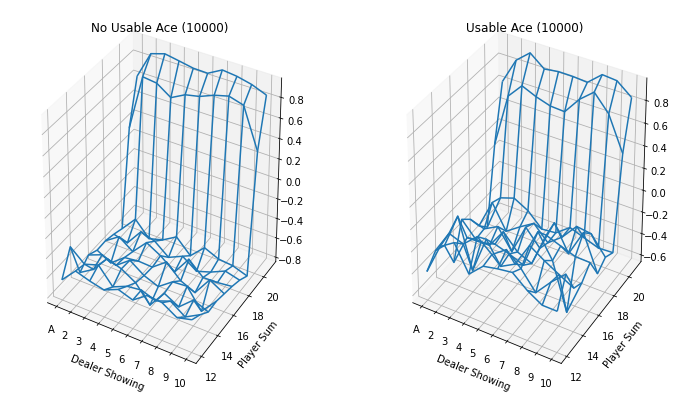

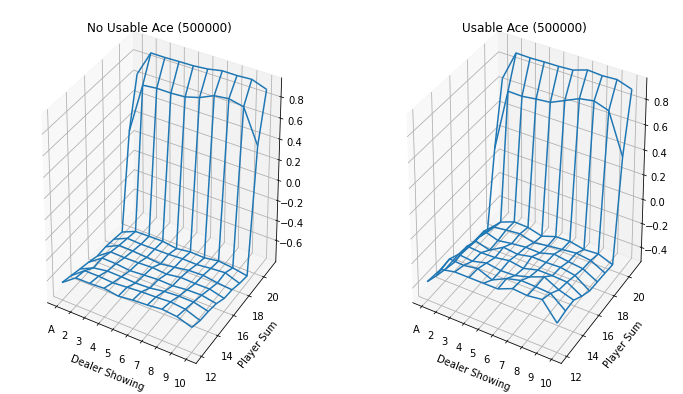

In [3]:
MonteCarlo_onPolicy(10000)
MonteCarlo_onPolicy(500000)

## On-Policy Monte-Carlo Value Improvement with Exploring Starts
This solution is inspired by solutions from [ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter05/blackjack.py) and [hollygrimm](https://github.com/hollygrimm/blackjack-montecarlo).

To be able to solve this problem, the entire trajectory of every episode needs to be stored and the returns for each action taken at each state in every episode is updated at the end of the episode.
I felt the problem statement is ambiguous and needed the above resources to fully understand the problem. I felt that the following points could have been elaborated in the problem statement:

*   Usable ace is not set per episode, but set per move. Suppose the user has a usable ace and decides to "hit" which brings the total to more than 21, the first state would have an usable ace and the 2nd would not. This is kinda mentioned but I did not understand it well.
*   The problem could have been started by assigning random initial states. My initial code contained generating the initial states and this took a lot of time.
*   The policy function can be defined within the monte-carlo approach and this would eliminate the need to copy the entire policy array at each episode/update
*   This is a random process, so to ensure each state is visited roughly the same number of times, the initial action is also set randomly regardless of the behavior (fixed) policy. If the initial action is not set, some states are reached too few times and this skews the greedy action at these states. The statistical properties of Monte-Carlo break down due to the lower sample sizes at these states without this condition.

### Code

In [4]:
def MonteCarlo_ES(first_visit_mc,num_episodes):
  action_value_reward = np.zeros((2,10,10,2))
  action_value_count = np.ones((2,10,10,2))
  action_value = action_value_reward/action_value_count

  def player_policy(state):
    val = action_value[state[0],state[1]-min_score,state[2]-1,:]
    max_val = np.max(val)
    best_actions = [a for a,v in enumerate(val) if v == max_val]
    return np.random.choice(best_actions)

  def player_fixed_policy(state):
    return fixed_policy(state[1],player_stick_val)

  def get_state_value():
    pass

  def plot_policy():
    xlabels = [str(i+1) for i in range(10)];
    xlabels[0] = 'A';

    fig,ax = plt.subplots(2,2)
    ax[0,0].matshow(np.argmax(action_value[0,:,:,:],axis=-1),cmap='binary')
    ax[0,1].matshow(np.argmax(action_value[1,:,:,:],axis=-1),cmap='binary')

    ax[0,0].set_xticks(list(range(0,10)))
    ax[0,0].set_yticks(list(range(-1,10)))

    ax[0,1].set_xticks(list(range(0,10)))
    ax[0,1].set_yticks(list(range(-1,10)))

    ax[0,0].set_title('No Usable Ace')
    ax[0,0].invert_yaxis()
    ax[0,0].set_xticklabels(xlabels)
    ax[0,0].xaxis.set_ticks_position('bottom')
    ax[0,0].set_yticklabels(list(range(11,22)));

    ax[0,1].set_title('Usable Ace')
    ax[0,1].invert_yaxis()
    ax[0,1].set_xticklabels(xlabels)
    ax[0,1].xaxis.set_ticks_position('bottom')
    ax[0,1].set_yticklabels(list(range(11,22)));

  for episode in tqdm(range(num_episodes)):
    initial_state = [np.random.choice([0, 1]),
                    np.random.choice(range(12, 22)),
                    np.random.choice(range(1, 11))]
    initial_action = np.random.choice([0,1])
    if episode == 0:
      reward,trajectory = play(player_fixed_policy,initial_state,initial_action)
    else:
      reward,trajectory = play(player_policy,initial_state,initial_action)
    unique_traj = set()  
    for t in trajectory:
      state = (t[0],t[1],t[2])
      action = t[3]
      if state[1] <= max_score:
        if state in unique_traj and first_visit_mc:
          continue
        unique_traj.add(state)
        action_value_reward[state[0],state[1]-min_score,state[2]-1,action] += reward
        action_value_count[state[0],state[1]-min_score,state[2]-1,action] += 1
        action_value[state[0],state[1]-min_score,state[2]-1,action] = action_value_reward[state[0],state[1]-min_score,state[2]-1,action]/action_value_count[state[0],state[1]-min_score,state[2]-1,action]
  print()
  print()
  plot_policy()

### Results

100%|██████████| 500000/500000 [00:53<00:00, 9371.59it/s]


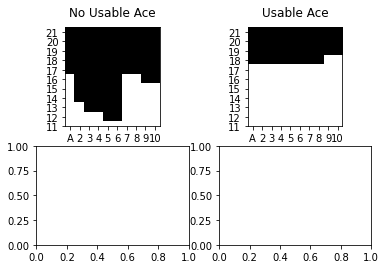

In [5]:
first_visit_mc = True
num_episodes = 500000
MonteCarlo_ES(first_visit_mc,num_episodes)    